# AcousticBrainz feature 
By Victor Badenas

### Plotting and analysis of the most instantiated generes' features present in AllMusic, Discogs, LastFM and TagTraum

First the environment is set:

In [1]:
import csv
import os
import pandas as pd
from collections import defaultdict
import sys
import numpy as np
import matplotlib.pyplot as plt
import json
import time
from IPython.display import clear_output

IMAGE_FOLDER = os.path.join(os.path.abspath(""),"Output Plots")
DATA_FOLDER = os.path.join(os.path.abspath(""), "Data Files")

if not os.path.isdir(IMAGE_FOLDER): os.makedirs(IMAGE_FOLDER)
if not os.path.isdir(DATA_FOLDER): os.makedirs(DATA_FOLDER)

# Part 1: Computing the Intersection

### Load all four datasets

Load them row by row using a reder object as we are only interested in the sound_id part and store the sound_id in a set:

In [2]:
allmusic_ids = set([])
file = os.path.join(DATA_FOLDER,"acousticbrainz-mediaeval2017-allmusic-train.tsv")
with open(file) as tsvfile:
    reader = csv.reader(tsvfile, delimiter='\t')
    for sound in reader:
        allmusic_ids.add(sound[0])
    allmusic_ids.discard("recordingmbid")

In [3]:
discogs_ids = set([])
file = os.path.join(DATA_FOLDER,"acousticbrainz-mediaeval2017-discogs-train.tsv") 
with open(file) as tsvfile:
    reader = csv.reader(tsvfile, delimiter='\t')
    for sound in reader:
        discogs_ids.add(sound[0])
    discogs_ids.discard("recordingmbid")

In [4]:
lastfm_ids = set([])
file = os.path.join(DATA_FOLDER,"acousticbrainz-mediaeval2017-lastfm-train.tsv") 
with open(file) as tsvfile:
    reader = csv.reader(tsvfile, delimiter='\t')
    for sound in reader:
        lastfm_ids.add(sound[0])
    lastfm_ids.discard("recordingmbid")

In [5]:
tagtraum_ids = set([])
file = os.path.join(DATA_FOLDER,"acousticbrainz-mediaeval2017-tagtraum-train.tsv") 
with open(file) as tsvfile:
    reader = csv.reader(tsvfile, delimiter='\t')
    for sound in reader:
        tagtraum_ids.add(sound[0])
    tagtraum_ids.discard("recordingmbid")

Compute the intersection for the ids of all four datasets

In [6]:
intersection_ids = allmusic_ids & discogs_ids & lastfm_ids & tagtraum_ids

# Print Part 1

In [7]:
print(len(intersection_ids))
intersection_ids

247716


{'d994d92a-00ec-4952-ad09-673237015141',
 '57e39cea-a9e4-4993-9e4b-d2072b3eedfa',
 '4b889888-3ebe-4c87-a2b3-00aa563d96dd',
 '204cc598-65bf-4e6b-9638-474010444977',
 '77ffca21-7fb6-428d-a8b9-27630dde2c9e',
 'de969190-a80e-464a-972b-9e78c0550991',
 '1325e251-659a-4ebd-a1c5-041d60e43842',
 '221a0f86-6350-4b47-bcc4-1e10cc65e671',
 'f935aeb8-5916-4018-adc9-d0d05a305383',
 'b84040ad-2c1d-49e5-84d8-24dc7c8bc49e',
 '66a096f6-a6b4-4856-abe3-74bb21cfbefc',
 '68f68e84-3af1-4ae5-bf24-9a6dcaa87518',
 '5e861af1-ce3f-4635-bb6f-095b3db1492b',
 'db2604db-753d-48f0-a36e-28d53a7eba27',
 '8961a6c8-872c-488b-846a-cfd12a8205ea',
 '873a0f9a-b20f-4cb9-b70e-dbb877368dc1',
 'ccb6d481-1474-40ec-9686-124bfc4b54d4',
 'a9297896-9370-41e2-8824-db0abffb4237',
 'ca1a2e14-e2fd-4eef-9660-c780409e3461',
 '12b8a177-1630-43cd-bac6-4f86c2209f41',
 'd0a10493-bda5-47ee-88a5-c7887473c5db',
 'c5738d69-8d73-40ca-a6be-53e934949ccb',
 '692f649f-7b10-45bd-bd6b-c71831226703',
 'eb423718-2f38-429f-95b4-48188e7d424c',
 'fd5e19b9-d5f3-

# Part 2: Get only one database and get the intersection info

### Load the LastFM dataset

Loading it as a pandas matrix and then compute the difference between the whole dataset and the intersection so that we are left only with the information of the intersection_ids

In [8]:
file = os.path.join(DATA_FOLDER,"acousticbrainz-mediaeval2017-lastfm-train.tsv") 
with open(file) as tsvfile:
    lastfm_sounds = pd.read_csv(file,sep='\t',index_col=0,low_memory=False)

remove the items in the dataframe that are not in the intersection set. 

In [9]:
diff = set(lastfm_sounds.index.tolist())-intersection_ids
lastfm_sounds = lastfm_sounds.drop(diff)

# Print Part 2

In [10]:
print(lastfm_sounds.shape)
lastfm_sounds

(247716, 11)


,releasegroupmbid,genre1,genre2,genre3,genre4,genre5,genre6,genre7,genre8,genre9,genre10
recordingmbid,,,,,,,,,,,
77a9cc42-cc81-49d8-893c-34b9a5b6559d,f848a1cb-11dd-3dfc-9097-47adbeb3671f,instrumental,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8eed6eed-24e7-4ac9-98dd-2e20502c1b13,a0394996-0923-324b-a176-cc1a572cb9e4,rock,rock---britpop,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
a05966c4-aaf8-4508-ba23-3193b5067fc0,3447ebd2-34ed-344e-8217-07a431ac398d,reggae,reggae---dub,world,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f32f4c52-a2e3-446f-be49-005ca0a0d2b3,bd26ea9e-7d2e-3bba-bd29-b132f94e8e99,world,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1a00a335-fead-46ec-8d4f-06e8341291ea,0f2ccf4d-d242-3c23-a419-ea548af51df3,electronic,electronic---ambient,electronic---trance,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012e82b-5fc5-477f-bffe-15478cf0d2d5,a40e27cb-c4c7-3473-8e39-f6a0fa0d2180,christian,christian---christianrock,rock,rock---emo,rock---punk,NaN,NaN,NaN,NaN,NaN
4468c33f-9c76-41b3-a860-025cafa16074,f191f6a4-5ab2-3a4e-b8df-9a637eed6fb8,rock,rock---classicrock,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1f5cc450-7ed3-4329-9f47-2a97b8cbd58a,cddfbf34-37a6-41b3-b60e-c8c3bd6a3495,jazz,jazz---acidjazz,jazz---nujazz,NaN,NaN,NaN,NaN,NaN,NaN,NaN
d1db03b5-4991-4282-9d9f-a704ac89793f,96eef15a-4926-3482-93a2-749553c5ef1e,latin,pop,pop---latinpop,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Save the intersection pandas dataframe to a tsv for the lines above to be only computed once

In [11]:
file = os.path.join(DATA_FOLDER,"acousticbrainz-mediaeval2017-lastfm-train-intersection.tsv")
with open(file,"w") as tsvfile:
    lastfm_sounds.to_csv(tsvfile,sep = '\t')

### Load if the intersection has already been computed and stored

In [12]:
file = os.path.join(DATA_FOLDER,"acousticbrainz-mediaeval2017-lastfm-train-intersection.tsv")
with open(file) as tsvfile:
    lastfm_sounds = pd.read_csv(tsvfile,sep = '\t',index_col=0,low_memory=False)

# Part 3: Reducing the dataset to the most occurrent

### Shortening the pandas matrix to the sounds with most frequent generes

First we do a counter for the generes and store it in a default_dictionary:

In [13]:
#get names of the columns (genre1, genre2, etc...)
col_names = list(lastfm_sounds)

#declare counter default dictionary
genere_counter = defaultdict(int)

#iterate through genre columns
for col in col_names[1:]:
    
    #for each column, get the list of that column's values for all sound_ids
    col_values = lastfm_sounds[col].tolist()
    
    #iterate in that list
    for genere in col_values:
        
        #if the genre has a subgenre, it will be of the format genre---subgenre, if it does not have a subgenre, ignore
        try:
            subgenere = genere.split("---")[1]
        except(AttributeError,IndexError) as e:
            subgenere = ''
        if subgenere != '' : genere_counter[genere] += 1

Then the N most frequent subgeneres are gotten and converted it to a list of genre---subgenre 

In [14]:
N = 20 #how many genres to consider

#create dataframe for the default dictionary containing {Genere:Times it is mentioned}
generespd = pd.DataFrame(list(genere_counter.items()))

#change dataframe's column and row values
generespd.columns = ["Genere","Count"]
generespd = generespd.set_index("Genere")

#get only the N largest in the Count column
generespd = generespd.nlargest(N, "Count")

#convert the index to list in order to compare further on
most_frequent = generespd.index.tolist()

Get only the sounds that have the most_frequent subgenres in the generes matrix and delete the generes that are not on the list even if the sound has one of the most_frequent subgeneres, as the subgeneres that are not in the list are not relevant for the exercise:

In [15]:
#make a copy of lastfm_sounds as pandas works by reference by default
lastfm_sounds_intersected_N = lastfm_sounds.copy() 

#iterate through the columns
for col in lastfm_sounds:
    
    #check for all the genres in most frequent and replace anything that is not there with a Nan
    lastfm_sounds_intersected_N[col] = lastfm_sounds[col].str.extract(r"\b^("+"|".join(most_frequent)+r")\b")
    
#Delete all rows and columns filled exclusively with Nan
lastfm_sounds_intersected_N = lastfm_sounds_intersected_N.dropna(how='all').dropna(axis='columns',how='all')

# Print Part 3

In [16]:
print(lastfm_sounds_intersected_N.shape)
lastfm_sounds_intersected_N.sort_index()

(124185, 9)


,genre2,genre3,genre4,genre5,genre6,genre7,genre8,genre9,genre10
recordingmbid,,,,,,,,,
00005a44-2152-4971-80c1-c217563845eb,metal---heavymetal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00005ac4-210c-4914-89ba-6279ea881809,rock---classicrock,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00007960-9d81-4192-b548-ad33d6b0ca54,rock---alternative,rock---indie,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0000d8a7-8a9b-4b9d-a95c-038c6cb66547,rock---indierock,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0000fb36-5ee0-44c5-9fa7-5c944d8a85ac,NaN,electronic---synthpop,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00012f9d-8397-4a51-8fd5-027d3b5ccd62,NaN,soul---rnb,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0001fac4-7624-450e-a57f-8c0676f1b3a4,rock---hardrock,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0001fc6f-e494-4c88-86e0-ff31c7fcf173,soul---funk,soul---rnb,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00033b82-6f72-42f3-afac-c8b5c99434a2,NaN,rock---punk,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Store the values of the matrix that has the N most frequent generes

In [17]:
file = os.path.join(DATA_FOLDER,"acousticbrainz-mediaeval2017-lastfm-train-intersection-20.tsv")
with open(file,"w") as tsvfile:
    lastfm_sounds_intersected_N.to_csv(tsvfile,sep = '\t')

### Open the file if the code above has already been run

In [18]:
file = os.path.join(DATA_FOLDER,"acousticbrainz-mediaeval2017-lastfm-train-intersection-20.tsv")
with open(file) as tsvfile:
    lastfm_sounds_intersected_N = pd.read_csv(tsvfile,sep = '\t',index_col=0,low_memory=False)

# Part 4: Prepare the features' data to be plotted 

### Open csv Files with the Features

After this, load the csv file with the features ...

In [19]:
file = os.path.join(DATA_FOLDER,"acousticbrainz-mediaeval2017-train-amplab2019-selected-features-mbid.csv")
with open(file) as csvfile:
    selected_features = pd.read_csv(csvfile,index_col = 0, low_memory = False)
selected_features.shape

(247716, 8)

... and compute the difference as it is done in the LoadFM dataset part, to drop the files that are not in the list of the sounds containing the N most frequent subgeneres:

In [20]:
diff_features = set(selected_features.index.tolist())-set(lastfm_sounds_intersected_N.index.tolist())
selected_features = selected_features.drop(diff_features)

# Print Part4

In [21]:
print(selected_features.shape)
selected_features.sort_index().head()

(124185, 8)


,lowlevel.average_loudness,metadata.audio_properties.length,metadata.audio_properties.replay_gain,rhythm.bpm,rhythm.danceability,rhythm.onset_rate,tonal.key_key,tonal.key_scale
mbid,,,,,,,,
00005a44-2152-4971-80c1-c217563845eb,0.902541,333.348572,-5.080051,128.858856,1.105704,2.669715,D,minor
00005ac4-210c-4914-89ba-6279ea881809,0.778497,274.756989,0.355402,142.368774,1.228754,3.260870,A#,major
00007960-9d81-4192-b548-ad33d6b0ca54,0.968310,191.440002,-12.583757,115.908508,1.148735,3.327064,A,minor
0000d8a7-8a9b-4b9d-a95c-038c6cb66547,0.937835,291.186676,-16.055473,90.996552,1.063905,3.094078,D,major
0000fb36-5ee0-44c5-9fa7-5c944d8a85ac,0.903276,291.030212,-16.016674,134.997910,1.110559,4.439092,D,minor


# Part 5: Plot of the features by genre 

### Computation of the features in a dictionary of genres

In [22]:
#initialize dictionary
information = {}

#loop through subgenres to create an entry in the dictionary for each subgenre where in each entry, a dictionary of
#the features will be created in order to get a dictionary of features for each genre in an organised manner.
for i,sub_genre in enumerate(most_frequent):
    
    print("Processing {0} out of {1}".format(i+1,len(most_frequent)))
    
    #temporal variable that copies the lastfm intersected N pandas matrix
    lastfm_sounds_intersected_N_temp = lastfm_sounds_intersected_N.copy()

    #iterate through columns for:
    #- All genres that are not the one in each iteration will be repaced with NaN
    #- All columns and sound ids that are not from that genere get deleted
    for col in lastfm_sounds_intersected_N_temp:
        
        lastfm_sounds_intersected_N_temp[col] = lastfm_sounds_intersected_N_temp[col].str.extract(r"\b^("+sub_genre+r")\b")

    lastfm_sounds_intersected_N_temp = lastfm_sounds_intersected_N_temp.dropna(how='all').dropna(how='all',axis='columns')
    
    #initializing the features dictionary for each subgenre
    information[sub_genre] = {}
    
    #for each feature, add the list features for each subgenre to the dictionary
    for feature in list(selected_features):
        
        #get only the feature that it's wanted
        temp = selected_features[feature].to_frame()
        
        #get only the information for the genre for this iteration
        temp = temp.drop(set(temp.index.tolist())-set(lastfm_sounds_intersected_N_temp.index.tolist()))
        
        #add entry to the dictionary
        information[sub_genre].update({ feature : temp[feature].tolist() })
    
    clear_output()

print("Done!")

Done!


### Plot of the features distribution

Once the dictionary containing all features for all subgenres as a 3D matrix or dictionary (subgenre,feature,data) the plot is computed from this hirearchy.

First, functions for plotting the barplot from a dictionary that contains the number of times a discrete feature ocurrs is done.

In [23]:
def plotbar(feature_name,counter,percentage,directory):
    
    file = os.path.join(directory,"{}.{}".format(feature_name,'png'))
    
    #initialize plot and axes objects
    fig, ax = plt.subplots()
    opacity = 0.8
    
    #get the strings for the features that will be on the legend.
    indexes_str = list(counter[list(counter.keys())[0]].keys())
    
    #get the genre strings and ints(for multibar plot purposes)
    genre_index_int = np.arange(len(list(counter.keys())))
    genre_index_str = list(counter.keys())
    
    #set the value of the bar width according to the number of bar that have to be plotted in each x value
    bar_width = 1/(1.25*len(indexes_str))
    
    #for multibar plot purposes
    i = 0
    
    #calculate the sum of values for each subgenre in order to normalize if desired
    norm_array = [] 
    for sub_genre in genre_index_str:
        norm = 0
        for index in indexes_str:
            norm += counter[sub_genre][index]
        norm_array.append(norm)
    
    #for each value of the legend:
    for index in indexes_str:
        
        #list of values to print
        val = []
        
        #for each value in x axis
        for sub_genre in counter.keys():
            
            #add the corresponding value to the list
            val.append(counter[sub_genre][index])
            
        if percentage:
            val[:] = [100*x/norm for x,norm in zip(val,norm_array)]
        
        #print the rectangle
        rects1 = plt.bar(genre_index_int + i*bar_width, val, bar_width, alpha=opacity, label=index)
        
        #for multibar plot purposes
        i += 1
        

    plt.xlabel('Genre')
    if percentage:
        plt.ylabel('Percentage')
    else:
        plt.ylabel('Appearances')
    plt.title(feature_name)
    plt.xticks(genre_index_int + i/2*bar_width, genre_index_str )
    plt.setp(ax.xaxis.get_majorticklabels(),rotation=45,ha="right")
    plt.legend()
    fig.set_size_inches(15,10)
    plt.savefig(file, dpi=100)
    plt.show()

Define a function for the boxplot given a list of arrays of data and a list of labels, do an horizontal plot

In [24]:
def plotbox(feature_name,list_data,list_names,directory):
    
    file = os.path.join(directory,"{}.{}".format(feature_name,'png'))
    
    #initalize figure and axis
    fig, ax = plt.subplots()
    
    #set title
    ax.set_title(feature_name)
    
    #plot the data with the list given horizontally
    ax.boxplot(list_data,labels=list_names,vert=False)
    
    fig.set_size_inches(15,10)
    plt.savefig(file, dpi=100)
    plt.show()

Do one plot or the other depending on the feature to plot. 

It is also saved a png image of the plot to an output image folder.

In [25]:
#loop though the features
for i,feature in enumerate(list(selected_features)):
    
    print("Processing {0} out of {1}".format(i+1,len(most_frequent)))
    
    #if the feature selected is the tonal key or the tonal scale:
    #- loop for each subgenre
    #- count the times a feature is repeated for each genre
    #- call plotbar function
    if (feature == 'tonal.key_key') | (feature == 'tonal.key_scale'):
        counter = {}
        for sub_genre in most_frequent:
            counter[sub_genre] = defaultdict(int)
            str_list = information[sub_genre][feature]
            for item in str_list:
                counter[sub_genre][item] += 1
        plotbar( feature_name = feature, counter = counter,percentage = True, directory = IMAGE_FOLDER)
    
    #if the feature is any other:
    #- get the data and store it in a list of arrays of data synced with the most_frequent features labels
    #- call plotbox function
    else:
        list_data = []
        list_names = most_frequent
        for sub_genre in most_frequent:
            list_data.append(information[sub_genre][feature])
        
        plotbox( feature_name=feature, list_data=list_data, list_names=list_names, directory = IMAGE_FOLDER)
        
    clear_output()

print("Done!")

Done!


# Part 6: Plot of High-Level data

The code below performs a scan of files through the folder containing the high level features and it stores the features as follows:
- indexes are mbid
- each column is the feature
- it has already checked that ids of the files are in the selected_features as well so that we don't waste resources on this.

## DISCLAIMER: this takes a long time (around 1h15 in an i7-6700HQ) if some other genere selection method wants to be used this part must be executed again if the same selection method wants to be done, just skip this cell and load the tsv file from disk

In [26]:
features_to_extract_from_json = [ "aggressive", "happy", "sad", "party", "relaxed","instrumental", "voice", "female", "male"]

labels_to_extract = ["mood_aggressive","mood_happy","mood_sad","mood_party","mood_relaxed","voice_instrumental", "voice_instrumental", "gender", "gender"] 

#print(features_to_extract_from_json,labels_to_extract)
sound_id_highlevel = selected_features.index.tolist()

folder_highlevel_features = os.path.join(DATA_FOLDER,"acousticbrainz-mediaeval-train-intersection-highlevel")

highlevel_features = pd.DataFrame(columns = features_to_extract_from_json)

numfolders = sum([1 for _, _, _ in os.walk(folder_highlevel_features)])
i = 1

for subdir, _, files in os.walk(folder_highlevel_features):
    
    starttime = time.clock()
    print("{}/{}".format(str(i),str(numfolders)))
    
    for file in files:
        
        filename, file_extension = os.path.splitext(file)
        
        file_absolute_path = os.path.join(subdir,file)
        
        if file_extension == ".json":
            
            if any(filename in s for s in sound_id_highlevel):
                
                temp_dict = {}
                temp_dict["mbid"] = filename
                
                with open(file_absolute_path) as jsonfile:
                    json_dict = json.load(jsonfile)
                    
                json_dict = json_dict["highlevel"]
                for label,feature in zip(labels_to_extract,features_to_extract_from_json):
                    temp_dict[feature] = json_dict[label]["all"][feature]
                    
                temp_dataframe = pd.DataFrame(temp_dict,index=[0])
                highlevel_features = pd.concat([highlevel_features,temp_dataframe],ignore_index = True,sort = True)
    
    time_expected = (time.clock()-starttime)*(numfolders-i)
    print(str(time_expected))
    i += 1
highlevel_features = highlevel_features.set_index("mbid").sort_index()

1/257
0.04275199999938195
2/257
2364.2452499999995
3/257
1798.9354419999997
4/257
2651.091619
5/257
2408.225148
6/257
2614.6358760000003
7/257
1766.48475
8/257
2343.707769
9/257
2317.4288079999997
10/257
2295.6234339999996
11/257
2348.0827919999997
12/257
2187.6660049999996
13/257
2174.374768
14/257
2396.3328359999964
15/257
1774.9468220000035
16/257
2603.583490999997
17/257
2575.6874400000015
18/257
1674.2184220000008
19/257
2312.9577800000006
20/257
2049.381659999998
21/257
2059.469103999999
22/257
2367.494809999999
23/257
2110.145310000002
24/257
2277.710605999997
25/257
2088.970223999997
26/257
2169.5979690000013
27/257
2092.982519999997
28/257
2409.996915999998
29/257
1747.6341360000079
30/257
2498.4387259999935
31/257
2386.105061999993
32/257
1649.372400000007
33/257
2036.2137599999987
34/257
1918.8871249999984
35/257
2069.414292
36/257
2215.193057999991
37/257
1782.404799999996
38/257
1555.5044399999977
39/257
2507.1658980000025
40/257
2446.2342729999978
41/257
1591.128143999998

Saving the highlevel_features to a tsv file

In [27]:
file = os.path.join(DATA_FOLDER,"acousticbrainz-mediaeval-train-intersection-highlevel-selectedfeatures.tsv")
with open(file,"w") as tsvfile:
    highlevel_features.to_csv(tsvfile,sep = '\t')

Read the highlevel_features from a tsv file

In [28]:
file = os.path.join(DATA_FOLDER,"acousticbrainz-mediaeval-train-intersection-highlevel-selectedfeatures.tsv")
with open(file) as tsvfile:
    highlevel_features = pd.read_csv(tsvfile,sep = '\t',index_col=0,low_memory=False)

Computation of the features in a dictionary of genres as before

In [29]:
#initialize dictionary
information_highlevel = {}

#loop through subgenres to create an entry in the dictionary for each subgenre where in each entry, a dictionary of
#the features will be created in order to get a dictionary of features for each genre in an organised manner.
for i,sub_genre in enumerate(most_frequent):
    
    print("Processing {0} out of {1}".format(i+1,len(most_frequent)))
    
    #temporal variable that copies the lastfm intersected N pandas matrix
    lastfm_sounds_intersected_N_temp = lastfm_sounds_intersected_N.copy()

    #iterate through columns for:
    #- All genres that are not the one in each iteration will be repaced with NaN
    #- All columns and sound ids that are not from that genere get deleted
    for col in lastfm_sounds_intersected_N_temp:
        
        lastfm_sounds_intersected_N_temp[col] = lastfm_sounds_intersected_N_temp[col].str.extract(r"\b^("+sub_genre+r")\b")

    lastfm_sounds_intersected_N_temp = lastfm_sounds_intersected_N_temp.dropna(how='all').dropna(how='all',axis='columns')
    
    #initializing the features dictionary for each subgenre
    information_highlevel[sub_genre] = {}
    
    #for each feature, add the list features for each subgenre to the dictionary
    for feature in list(highlevel_features):
        
        #get only the feature that it's wanted
        temp = highlevel_features[feature].to_frame()
        
        #get only the information_highlevel for the genre for this iteration
        temp = temp.drop(set(temp.index.tolist())-set(lastfm_sounds_intersected_N_temp.index.tolist()))
        
        #add entry to the dictionary
        information_highlevel[sub_genre].update({ feature : temp[feature].tolist() })

    clear_output()

print("Done!")

Done!


Create plots for each feature

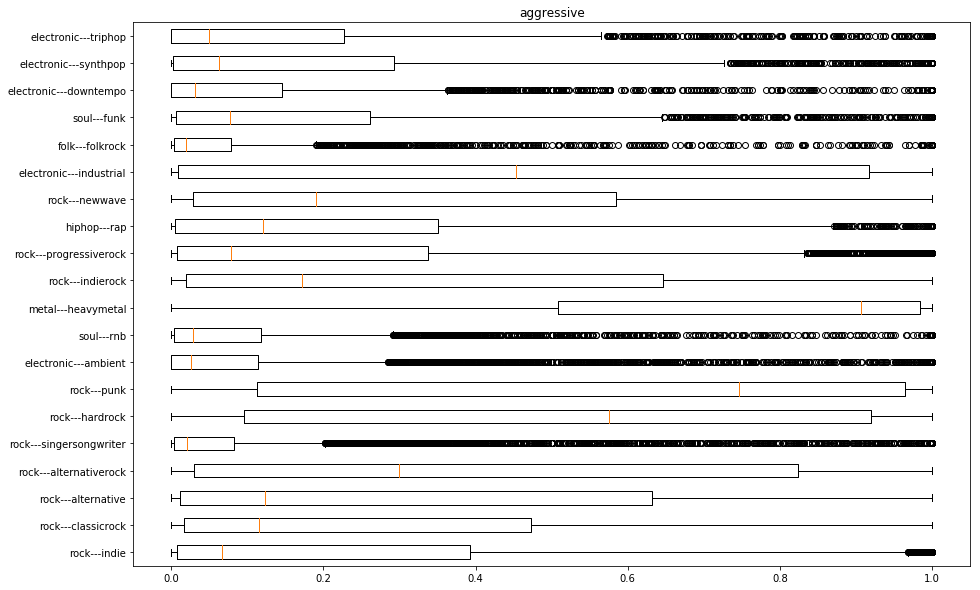

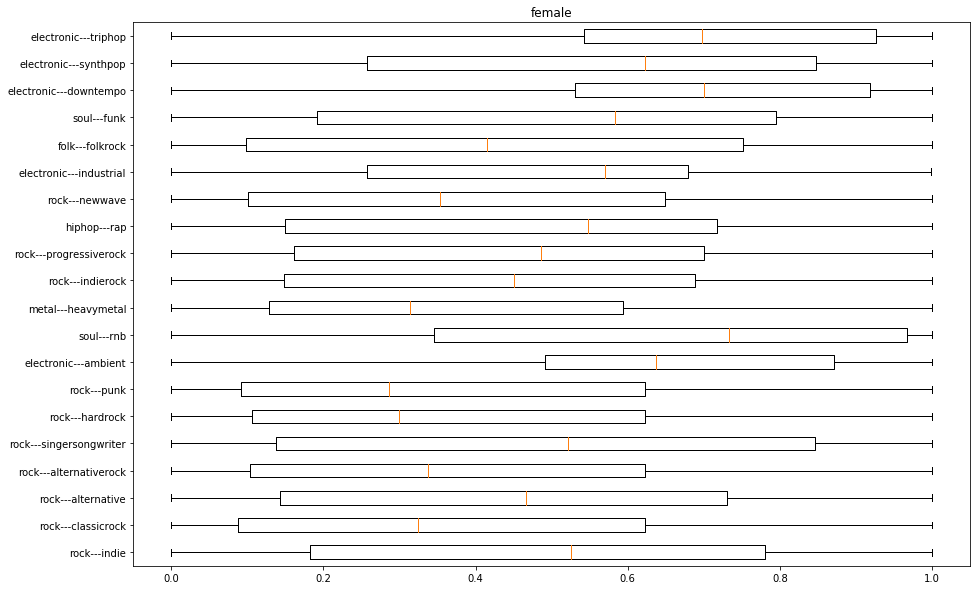

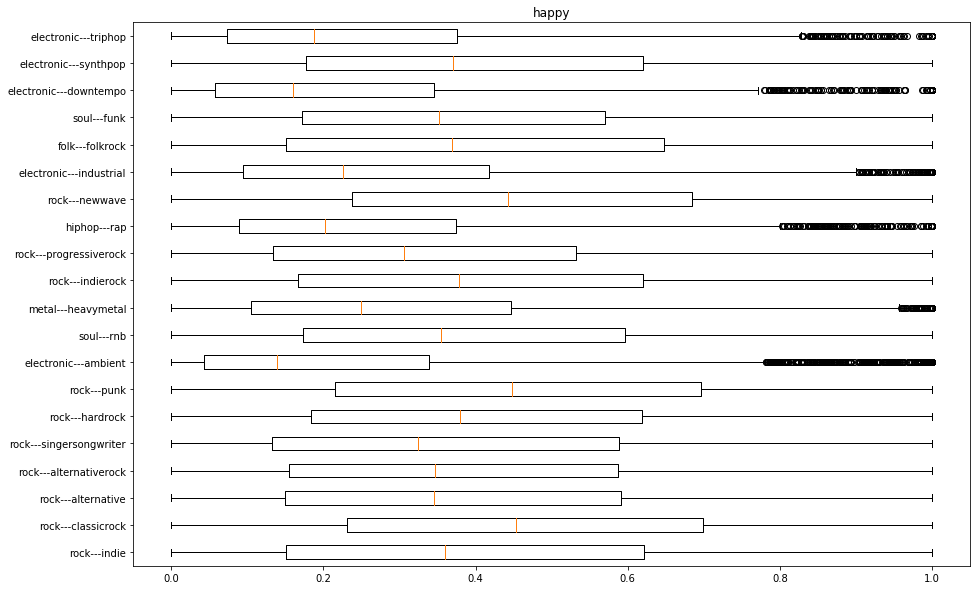

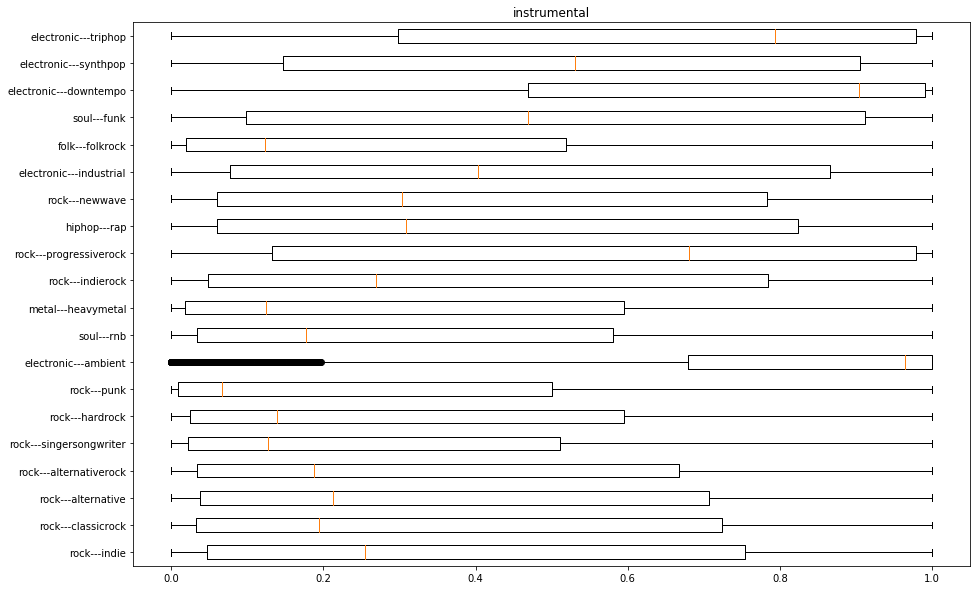

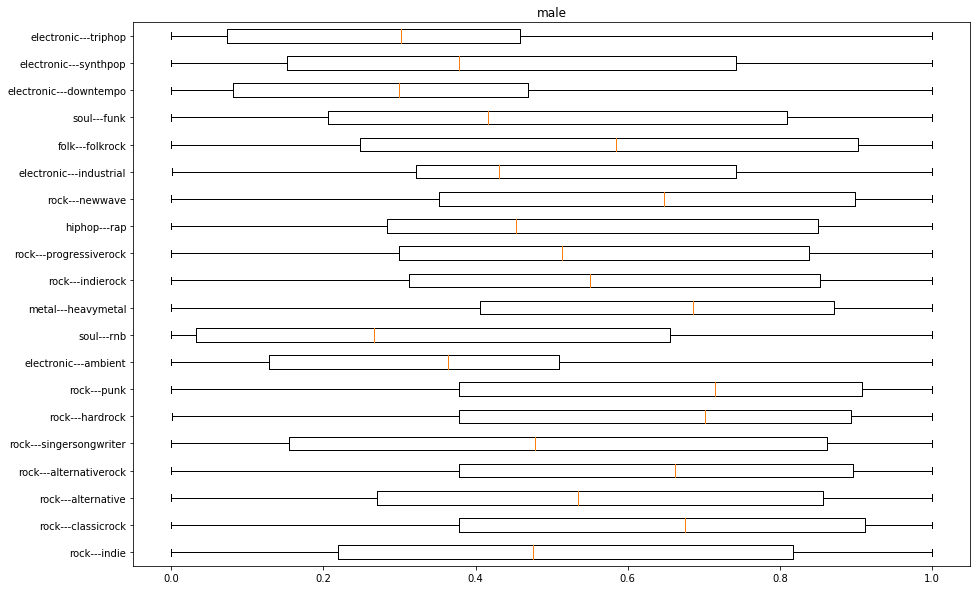

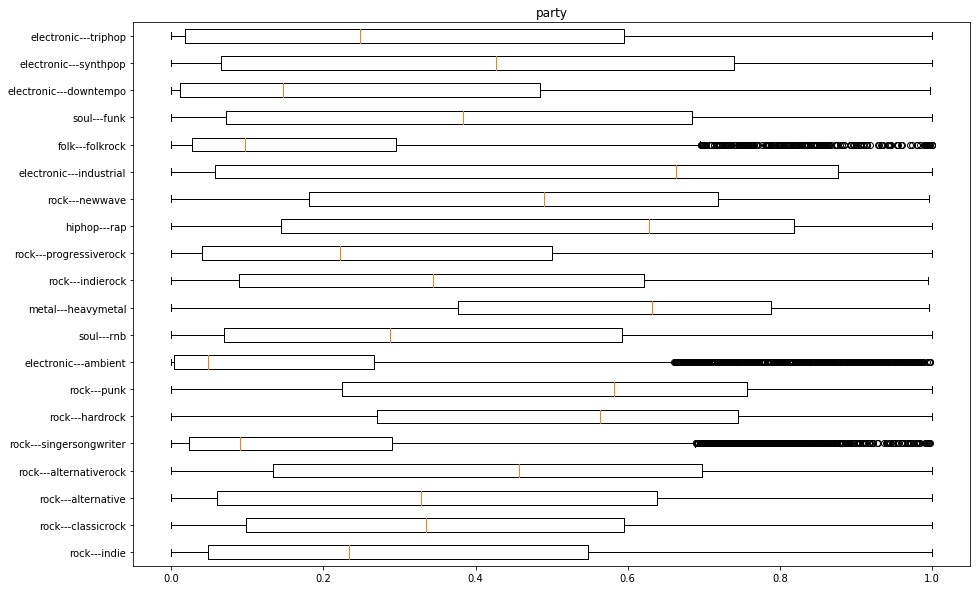

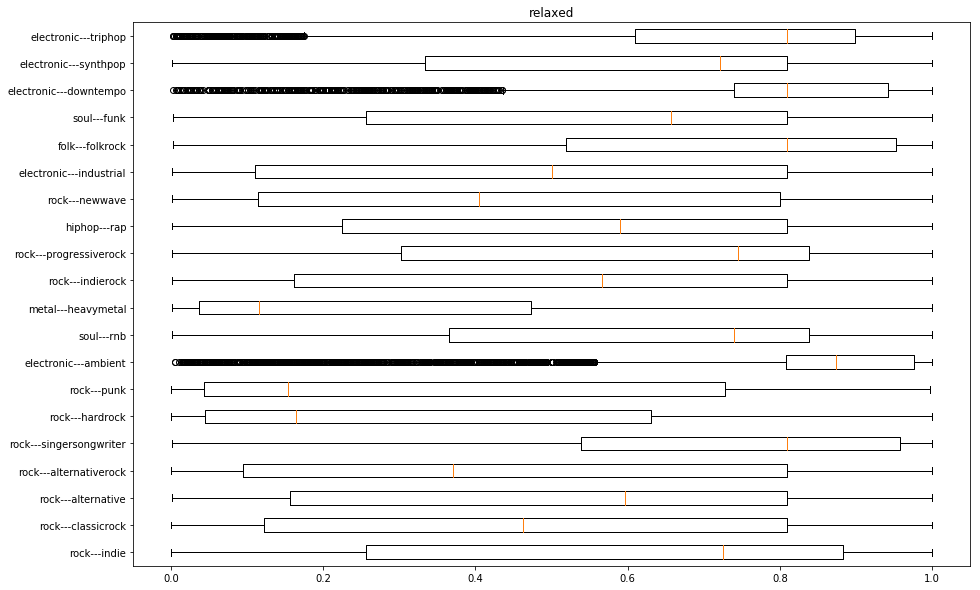

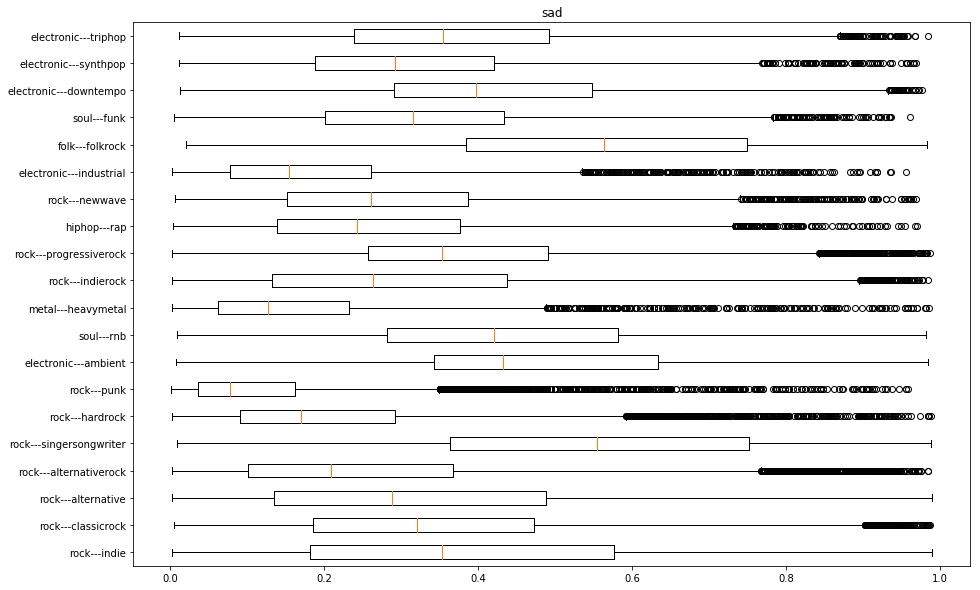

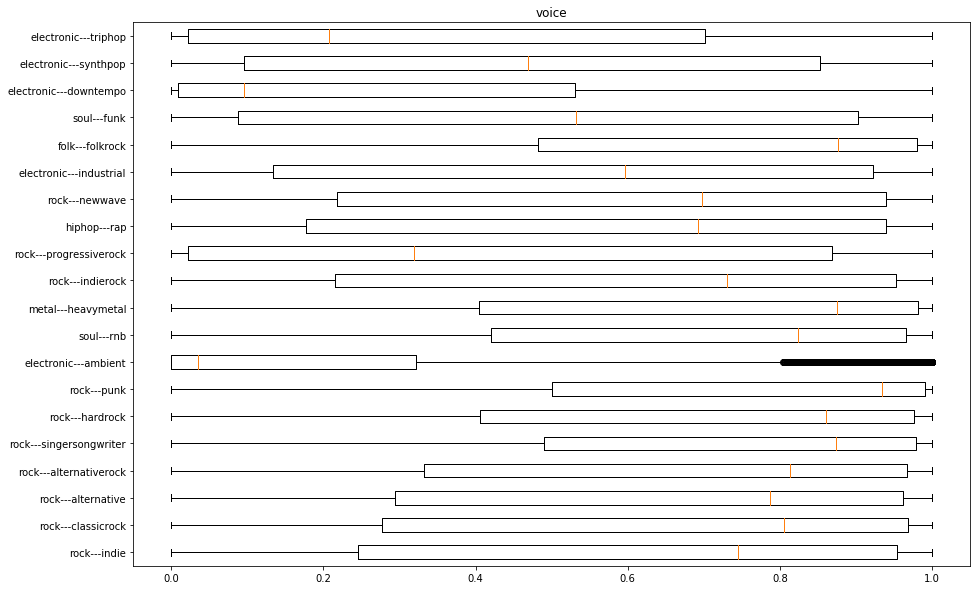

In [30]:
for feature in list(highlevel_features):
    
    #- get the data and store it in a list of arrays of data synced with the most_frequent features labels
    #- call plotbox function
    list_data = []
    list_names = most_frequent
    for sub_genre in most_frequent:
        list_data.append(information_highlevel[sub_genre][feature])

    plotbox( feature_name=feature, list_data=list_data, list_names=list_names, directory = IMAGE_FOLDER)

## Now the same is done for instrumental voice female and male features

Same procedure as before: scan all the json files searching for the features